# Convert files

In [1]:
import surfradpy.mfr_raw2netcdf as mfr_r2nc

In [2]:
reload(mfr_r2nc)

<module 'surfradpy.mfr_raw2netcdf' from '/home/hagen/prog/SURFRAD/surfradpy/mfr_raw2netcdf.py'>

In [3]:
'/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.netcdf/v0.1/'

'/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.netcdf/v0.1/'

In [4]:
ci = mfr_r2nc.MfrsrRawToNetcdf('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serialnumber}',
                      '/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serialnumber}.netcdf/v{version}/',
                      'frc_{serialnumber}_{year}{month}{day}.nc',
                      serialnumber = '648',)
ds = ci.process()

1


sh: 1: getfattr: not found


Last file was incomplet
.....

In [5]:
ci = mfr_r2nc.MfrsrRawToNetcdf('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serialnumber}',
                      '/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serialnumber}.netcdf/v{version}/',
                      'frc_{serialnumber}_{year}{month}{day}.nc',
                      serialnumber = '649',)
ds = ci.process()

1


sh: 1: getfattr: not found


Last file was incomplet
.....

# Lets plots some 

In [6]:
%matplotlib widget

In [7]:
ds = xr.open_mfdataset(pl.Path('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.netcdf/v0.1').glob('*'))

sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


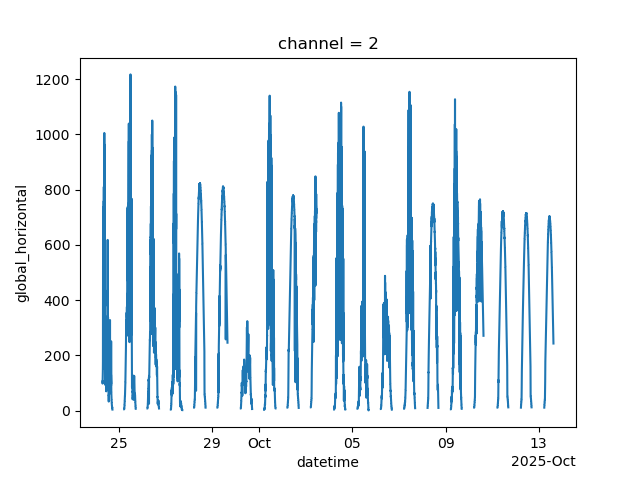

In [8]:
ds.global_horizontal.sel(channel = 2).plot.line(x = 'datetime')

In [9]:
ds = xr.open_mfdataset(pl.Path('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/649.netcdf/v0.1').glob('*'))

sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found


In [10]:
ds.global_horizontal.sel(channel = 2).plot.line(x = 'datetime')